In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
# https://blog.csdn.net/BXD1314/article/details/126187598
import math
import numpy as np

In [1]:
device=100
epochs=100
sentences = [
    # 中文和英语的单词个数不要求相同
    # enc_input                dec_input           dec_output
    ['我 有 一 个 好 朋 友 P', 'S I have a good friend .', 'I have a good friend . E'],
    ['我 有 零 个 女 朋 友 P', 'S I have zero girl friend .', 'I have zero girl friend . E'],
    ['我 有 一 个 男 朋 友 P', 'S I have a boy friend .', 'I have a boy friend . E']
]

src_vocab = {'P': 0, '我': 1, '有': 2, '一': 3,
             '个': 4, '好': 5, '朋': 6, '友': 7, '零': 8, '女': 9, '男': 10}
src_idx2word = {i: w for i, w in enumerate(src_vocab)}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'I': 1, 'have': 2, 'a': 3, 'good': 4,
             'friend': 5, 'zero': 6, 'girl': 7,  'boy': 8, 'S': 9, 'E': 10, '.': 11}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 8  # （源句子的长度）enc_input max sequence length
tgt_len = 7  # dec_input(=dec_output) max sequence length

# Transformer Parameters
d_model = 512  # Embedding Size（token embedding和position编码的维度）
# FeedForward dimension (两次线性层中的隐藏层 512->2048->512，线性层是用来做特征提取的），当然最后会再接一个projection层
d_ff = 2048
d_k = d_v = 64  # dimension of K(=Q), V（Q和K的维度需要相同，这里为了方便让K=V）
n_layers = 6  # number of Encoder of Decoder Layer（Block的个数）
n_heads = 8  # number of heads in Multi-Head Attention（有几套头）

In [32]:
def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
        enc_inputs.append([src_vocab[n] for n in sentences[i][0].split()])
        dec_inputs.append([tgt_vocab[n] for n in sentences[i][1].split()])
        dec_outputs.append([tgt_vocab[n] for n in sentences[i][2].split()])
        #[[1, 2, 3, 4, 5, 6, 7, 0], [1, 2, 8, 4, 9, 6, 7, 0], [1, 2, 3, 4, 10, 6, 7, 0]]
        #[[9, 1, 2, 3, 4, 5, 11], [9, 1, 2, 6, 7, 5, 11], [9, 1, 2, 3, 8, 5, 11]]
        #[[1, 2, 3, 4, 5, 11, 10], [1, 2, 6, 7, 5, 11, 10], [1, 2, 3, 8, 5, 11, 10]]
    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)
print(enc_inputs,dec_inputs,dec_outputs)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  0],
        [ 1,  2,  8,  4,  9,  6,  7,  0],
        [ 1,  2,  3,  4, 10,  6,  7,  0]]) tensor([[ 9,  1,  2,  3,  4,  5, 11],
        [ 9,  1,  2,  6,  7,  5, 11],
        [ 9,  1,  2,  3,  8,  5, 11]]) tensor([[ 1,  2,  3,  4,  5, 11, 10],
        [ 1,  2,  6,  7,  5, 11, 10],
        [ 1,  2,  3,  8,  5, 11, 10]])


In [33]:
class MyDataSet(Data.Dataset):
    """自定义DataLoader"""

    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]

    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]


loader = Data.DataLoader(
    MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout=0.1,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(p=dropout)
        self.pe=torch.zeros(max_len,d_model) # 创建一个pe矩阵，大小为max_len*d_model
        position=torch.arange(0,max_len,dtype=torch.float).unsqueeze(1) # 创建一个位置向量，大小为max_len*1,这里的位置是词的位置，词的位置从0开始，加一个维度是为了方便广播机制
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model)) # 创建一个分母向量，大小为d_model/2
        print( position.shape,div_term.shape)
        print( (position*div_term).shape)
        self.pe[:,0::2]=torch.sin(position*div_term)
        self.pe[:,1::2]=torch.cos(position*div_term)
        self.pe=self.pe.unsqueeze(0).transpose(0,1)
        print(self.pe.shape)
        self.register_buffer('pe',self.pe)  # 放入缓存区
    
    def forward(self,x):
        """
        x: [seq_len, batch_size, d_model]
        """
        x=x+self.pe[:x.size(0),:]
        return self.dropout(x)
pe=PositionalEncoding(d_model)

torch.Size([5000, 1]) torch.Size([256])
torch.Size([5000, 256])
torch.Size([5000, 1, 512])


In [ ]:
def get_attn_pad_mask(seq_q, seq_k):
    # pad mask的作用：在对value向量加权平均的时候，可以让pad对应的alpha_ij=0，这样注意力就不会考虑到pad向量
    """这里的q,k表示的是两个序列（跟注意力机制的q,k没有关系），例如encoder_inputs (x1,x2,..xm)和encoder_inputs (x1,x2..xm)
    encoder和decoder都可能调用这个函数，所以seq_len视情况而定
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    """
    batch_size, len_q = seq_q.size()  # 这个seq_q只是用来expand维度的
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    # 例如:seq_k = [[1,2,3,4,0], [1,2,3,5,0]]
    # [batch_size, 1, len_k], True is masked
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    # [batch_size, len_q, len_k] 构成一个立方体(batch_size个这样的矩阵)
    return pad_attn_mask.expand(batch_size, len_q, len_k)

In [37]:
dataset=MyDataSet(enc_inputs,dec_inputs,dec_outputs)
print(dataset[0][0])

tensor([1, 2, 3, 4, 5, 6, 7, 0])


(512,)
(512,)
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 17

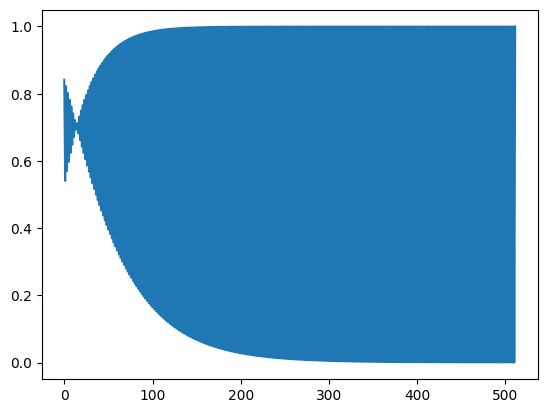

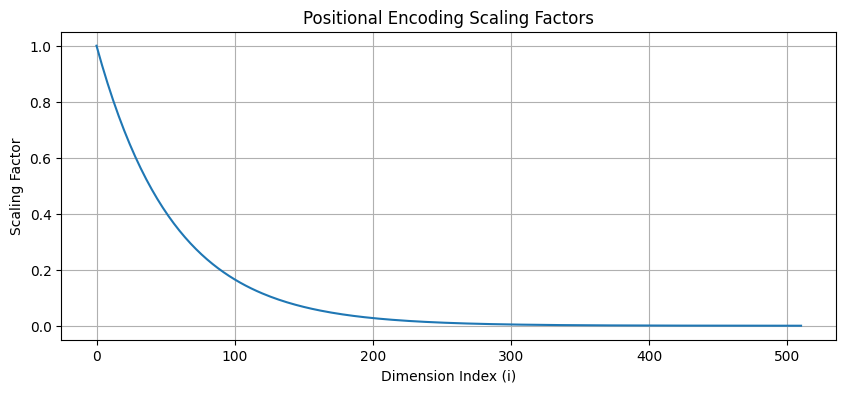

In [29]:
import matplotlib.pyplot as plt

d_model = 512
i = torch.arange(0, d_model, 2)
div_term = torch.exp(i * (-math.log(10000) / d_model))

# k = torch.arange(0, d_model, 1)
# div_term2 = torch.exp(k * (-math.log(10000) / d_model))

j=torch.arange(0, d_model, 1)
print(j.numpy().shape)
pe=torch.zeros(d_model)
print(pe.numpy().shape)
pe[0::2]=torch.sin(div_term)
pe[1::2]=torch.cos(div_term)
plt.plot(j.numpy(), pe.numpy())
print(j,pe)

plt.figure(figsize=(10, 4))
plt.plot(i.numpy(), div_term.numpy())
plt.title("Positional Encoding Scaling Factors")
plt.xlabel("Dimension Index (i)")
plt.ylabel("Scaling Factor")
plt.grid(True)
plt.show()
#缩放因子随维度增加指数下降